In [1]:
import os
GPU_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import cudf as gd
import pandas as pd
import numpy as np
import time
from collections import OrderedDict,Counter
from nvstring_workaround import on_gpu
from sklearn.model_selection import KFold
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

## This notebook contains a rapids solution to achieve 0.695 private LB in 12 minutes

### Functions

In [3]:
def rm_cols(gdf,cols):
    gcols = [i for i in gdf.columns]
    for col in cols:
        if col in gcols:
            gdf.drop_column(col)
    return gdf

def reset_col_dtype(gtr,gte):
    for col in gtr.columns:
        a,b = str(gtr[col].dtype),str(gte[col].dtype)
        if a!=b:
            gtr[col] = gtr[col].astype('float32')
            gte[col] = gte[col].astype('float32')
    return gtr,gte

def count_encode(df,cols):
    df['idx'] = np.arange(len(df))
    for col in cols:
        df[col] = df[col].fillna(-999)
        dg = df.groupby(col).agg({col:'count'})
        dg.columns = ['count_%s'%col]
        dg = dg.reset_index()
        df = df.merge(dg,on=[col],how='left')
        df.drop_column(col)
    df = df.sort_values(by='idx')
    df.drop_column('idx')
    df = rm_cols(df,[i for i in df.columns if i.startswith('count_')==0])
    return df

def count_encode_cpu(df,cols):
    for col in cols:
        dg = df.groupby(col).agg({col:'count'})
        dg.columns = ['count_%s'%col]
        df = df.merge(dg.reset_index(),on=[col],how='left')
    return df[[i for i in df.columns if i.startswith('count_')]]

In [4]:
def mtr(tr,col,te):
    tr[col] = tr[col].fillna(-999)
    tr[YCOL] = tr[YCOL].astype('float32')
    dg = tr.groupby(col).agg({YCOL:'mean'})
    dg.columns = ['mtr_%s'%col]
    dg = dg.reset_index()
    te = te.merge(dg,on=[col],how='left')
    del dg
    return te

def mtr_encode(tr,te,cols):
    tr['idx'] = np.arange(len(tr))
    tr['random'] = np.random.random(len(tr))
    tr = tr.sort_values(by='random')
    tr.drop_column('random')
    N = len(tr)//2
    tr1 = tr[:N]
    tr2 = tr[N:]
    te['idx'] = np.arange(len(te))
    for col in cols:
        if col not in tr.columns:
            continue
        tr2 = mtr(tr1,col,tr2)
        tr1 = mtr(tr2,col,tr1)
        te = mtr(tr,col,te)
    if len(tr1.columns)!=len(tr2.columns):
        del tr1,tr2
        return rm_cols(tr,[i for i in tr.columns]),rm_cols(te,[i for i in te.columns])
    del tr
    tr = gd.concat([tr1,tr2])
    tr = tr.sort_values(by='idx')
    tr = rm_cols(tr,[i for i in tr.columns if i.startswith('mtr_')==0])
    del tr1,tr2
    te = te.sort_values(by='idx')
    te = rm_cols(te,[i for i in te.columns if i.startswith('mtr_')==0])
    return tr,te

In [5]:
def mtr_cpu(tr,col,te):
    dg = tr.groupby(col).agg({YCOL:'mean'})
    dg.columns = ['mtr_%s'%col]
    te = te.merge(dg.reset_index(),on=[col],how='left')
    del dg
    return te

def mtr_encode_cpu(tr,te,cols):
    tr['idx'] = np.arange(len(tr))
    tr['random'] = np.random.random(len(tr))
    tr = tr.sort_values(by='random')
    tr.drop('random',axis=1,inplace=True)
    N = len(tr)//2
    tr1 = tr[:N]
    tr2 = tr[N:]
    te['idx'] = np.arange(len(te))
    for col in cols:
        if col not in tr.columns:
            continue
        tr2 = mtr_cpu(tr1,col,tr2)
        tr1 = mtr_cpu(tr2,col,tr1)
        te = mtr_cpu(tr,col,te)
    del tr
    tr = pd.concat([tr1,tr2],axis=0).reset_index(drop=True)
    tr = tr.sort_values(by='idx')
    cols = [i for i in tr.columns if i.startswith('mtr_')]
    tr = tr[cols]
    del tr1,tr2
    te = te.sort_values(by='idx')
    te = te[cols]
    return tr,te

### Read data & label encode

In [6]:
timing_gpu={}
timing_cpu={}

#### GPU

In [7]:
%%time
start = time.time()
step = "read data & label encode"

IDCOL = 'MachineIdentifier'
YCOL = 'HasDetections'

PATH = '.'
tr_path = '%s/train.csv'%PATH
te_path = '%s/test.csv'%PATH
gtr = gd.read_csv(tr_path)
gte = gd.read_csv(te_path)

for col in gtr.columns:
    if gtr[col].dtype=='object':
        gtr[col] = gtr[col].hash_values()
for col in gte.columns:
    if gte[col].dtype=='object':
        gte[col] = gte[col].hash_values()   

timing_gpu[step] = time.time()-start

CPU times: user 10.1 s, sys: 5.04 s, total: 15.1 s
Wall time: 15.1 s


#### CPU

In [8]:
%%time
start = time.time()

dtr = pd.read_csv(tr_path)
dte = pd.read_csv(te_path)

N = dtr.shape[0]
df = pd.concat([dtr,dte],axis=0).reset_index(drop=True)

for col in df.columns:
    if col != IDCOL and df[col].dtype=='O':
        df[col],_ = df[col].factorize()
        print(col,'done')
        
dtr,dte = df.iloc[:N].reset_index(drop=True),df.iloc[N:].reset_index(drop=True)
timing_cpu[step] = time.time()-start

AppVersion done
AvSigVersion done
Census_ActivationChannel done
Census_ChassisTypeName done
Census_DeviceFamily done
Census_FlightRing done
Census_GenuineStateName done
Census_InternalBatteryType done
Census_MDC2FormFactor done
Census_OSArchitecture done
Census_OSBranch done
Census_OSEdition done
Census_OSInstallTypeName done
Census_OSSkuName done
Census_OSVersion done
Census_OSWUAutoUpdateOptionsName done
Census_PowerPlatformRoleName done
Census_PrimaryDiskTypeName done
Census_ProcessorClass done
EngineVersion done
OsBuildLab done
OsPlatformSubRelease done
OsVer done
Platform done
Processor done
ProductName done
PuaMode done
SkuEdition done
SmartScreen done
CPU times: user 17min 52s, sys: 5min 32s, total: 23min 25s
Wall time: 6min 43s


### Count encoding

#### GPU

In [9]:
%%time
start = time.time()
step = "count encode"

count_cols = ['CityIdentifier', 'Census_OSBuildRevision', 'Census_TotalPhysicalRAM']
N = len(gtr)
gtr1,gte1 = gtr[count_cols],gte[count_cols]
gtr1,gte1 = reset_col_dtype(gtr1,gte1)
df = gd.concat([gtr1,gte1])
del gtr1,gte1

df = count_encode(df,count_cols)
data = df.to_pandas().values
del df
count_tr,count_te = data[:N],data[N:]
count_cols = ['count_%s'%i for i in count_cols]

timing_gpu[step] = time.time()-start

CPU times: user 6.13 s, sys: 972 ms, total: 7.1 s
Wall time: 3.26 s


#### CPU

In [10]:
%%time
start = time.time()

cols = ['CityIdentifier', 'Census_OSBuildRevision', 'Census_TotalPhysicalRAM']
N = len(gtr)
N = len(dtr)
dtr1,dte1 = dtr[cols],dte[cols]
df = pd.concat([dtr1,dte1],axis=0)

df = count_encode_cpu(df,cols)
data = df.values
count_tr_cpu,count_te_cpu = data[:N],data[N:]

timing_cpu[step] = time.time()-start

CPU times: user 1min 21s, sys: 8.28 s, total: 1min 29s
Wall time: 12.6 s


### Target encoding

#### GPU

In [11]:
%%time
start = time.time()
step = "target encode"

mtr_cols = ['SmartScreen']
gtr1 = gtr[mtr_cols+[YCOL]] 
gte1 = gte[mtr_cols]

gtr1,gte1 = mtr_encode(gtr1,gte1,mtr_cols)
mtr_tr,mtr_te = gtr1.to_pandas(),gte1.to_pandas()
mtr_cols = [i for i in mtr_tr.columns]
mtr_tr,mtr_te = mtr_tr.values,mtr_te.values
del gtr1,gte1

timing_gpu[step] = time.time()-start

CPU times: user 6.57 s, sys: 824 ms, total: 7.39 s
Wall time: 1.74 s


#### CPU

In [12]:
%%time
start = time.time()

cols = ['SmartScreen']
dtr1 = dtr[cols+[YCOL]] 
dte1 = dte[cols]

dtr1,dte1 = mtr_encode_cpu(dtr1,dte1,cols)
mtr_tr_cpu,mtr_te_cpu = dtr1.values,dte1.values

timing_cpu[step] = time.time()-start

CPU times: user 1min 57s, sys: 9.13 s, total: 2min 6s
Wall time: 10.1 s


#### target encode on gpu will be much faster if the column has many levels. Unfortunately 'SmartScreen' only has several levels.

### remove columns & combine all features

#### GPU 

In [13]:
%%time
start = time.time()
step = "combine"

badcols = ['PuaMode','OsSuite','ProductName','SmartScreen']
y = gtr[YCOL].to_pandas().values

gtr = rm_cols(gtr,[IDCOL,YCOL]+badcols)
gte = rm_cols(gte,[IDCOL,YCOL]+badcols)

tr = gtr.to_pandas()
te = gte.to_pandas()

cols = [i for i in tr.columns]
tr,te = tr.values,te.values

train = np.hstack([tr,count_tr,mtr_tr])
test = np.hstack([te,count_te,mtr_te])
feature_names = cols + count_cols + mtr_cols

print(train.shape, test.shape)
#print(cols)
timing_gpu[step] = time.time()-start

(8921483, 81) (7853253, 81)
CPU times: user 3min 6s, sys: 1min 44s, total: 4min 50s
Wall time: 10.2 s


#### CPU

In [14]:
%%time
start = time.time()

badcols = ['PuaMode','OsSuite','ProductName','SmartScreen']
usecols = [i for i in dtr.columns if i not in badcols+[IDCOL,YCOL]]
dtr = dtr[usecols].values
dte = dte[usecols].values

train_cpu = np.hstack([dtr,count_tr_cpu,mtr_tr_cpu])
test_cpu = np.hstack([dte,count_te_cpu,mtr_te_cpu])

print(train_cpu.shape, test_cpu.shape)
#print(cols)
timing_cpu[step] = time.time()-start

(8921483, 81) (7853253, 81)
CPU times: user 40 s, sys: 49 s, total: 1min 28s
Wall time: 17.7 s


In [15]:
xgb_cpu_params =  {
        'objective': 'binary:logistic',
        'tree_method': 'hist',
        'eta':0.1,
        'nthread': 16,
        'max_depth': 10,
        'silent':1,
        'subsample':0.8,
        'colsample_bytree': 0.7,
        'min_child_weight':10,
        'eval_metric':'auc',
}

xgb_gpu_params = xgb_cpu_params.copy()
xgb_gpu_params.update({'tree_method': 'gpu_hist',})

### Train & Predict

#### GPU

In [16]:
%%time
start = time.time()
step = "train & predict"


pred = 0
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for i,(train_index, test_index) in enumerate(kf.split(train)):
    y_train,y_test = y[train_index],y[test_index]
    X_train,X_test = train[train_index],train[test_index]
    watchlist = ()
    dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(data=test, feature_names=feature_names)
    clf = xgb.train(xgb_gpu_params, dtrain=dtrain,
                num_boost_round=500,evals=watchlist,
                early_stopping_rounds=None,maximize=True,
                verbose_eval=100)
    pred += clf.predict(dtest)
    print('fold',i,'done')
pred /= (i+1)

timing_gpu[step] = time.time()-start

fold 0 done
fold 1 done
fold 2 done
fold 3 done
CPU times: user 6min 48s, sys: 3min 35s, total: 10min 24s
Wall time: 10min 17s


#### CPU

In [17]:
%%time
start = time.time()

pred_cpu = 0
kf = KFold(n_splits=4, shuffle=True, random_state=42)
for i,(train_index, test_index) in enumerate(kf.split(train_cpu)):
    y_train,y_test = y[train_index],y[test_index]
    X_train,X_test = train_cpu[train_index],train_cpu[test_index]
    watchlist = ()
    dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(data=test_cpu, feature_names=feature_names)
    clf = xgb.train(xgb_cpu_params, dtrain=dtrain,
                num_boost_round=500,evals=watchlist,
                early_stopping_rounds=None,maximize=True,
                verbose_eval=100)
    pred_cpu += clf.predict(dtest)
    print('fold',i,'done')
pred_cpu /= (i+1)

timing_cpu[step] = time.time()-start

fold 0 done
fold 1 done
fold 2 done
fold 3 done
CPU times: user 8h 11min 58s, sys: 22min 38s, total: 8h 34min 37s
Wall time: 34min 15s


### Summary

In [18]:
#sub = pd.read_csv('%s/sample_submission.csv'%PATH)
#sub[YCOL] = pred
#sub.to_csv('rapids_sub.csv.gz',index=False,compression='gzip')

In [19]:
timing_gpu['train & predict']

617.4223990440369

In [20]:
steps = ['read data & label encode','count encode','target encode','combine','train & predict']
timing_gpu['Overall'] = sum([timing_gpu[i] for i in steps])
steps.append('Overall')
gpu_time = [timing_gpu[i] for i in steps]

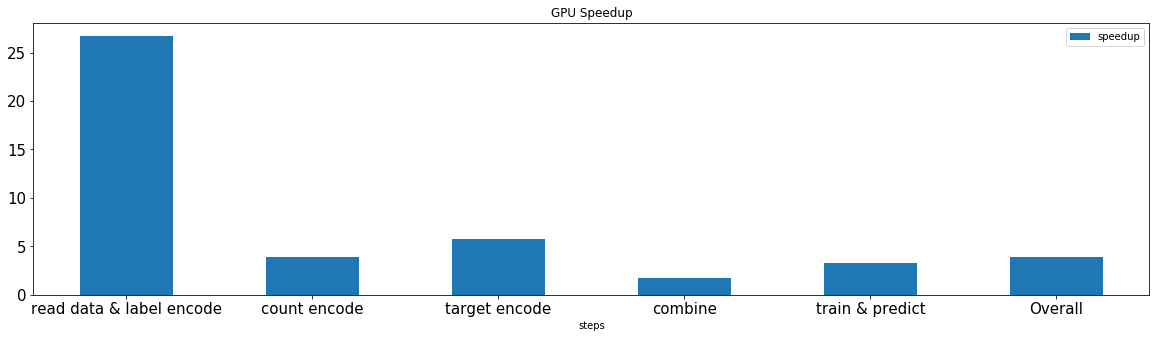

In [21]:
timing_cpu['Overall'] = sum([timing_cpu[i] for i in steps[:-1]])
speedup = [timing_cpu[i]/timing_gpu[i] for i in steps]
df = pd.DataFrame({'steps':steps, 'speedup':speedup})
df.plot.bar(x='steps', y='speedup', rot=0, figsize=(20,5), fontsize=15, title='GPU Speedup')

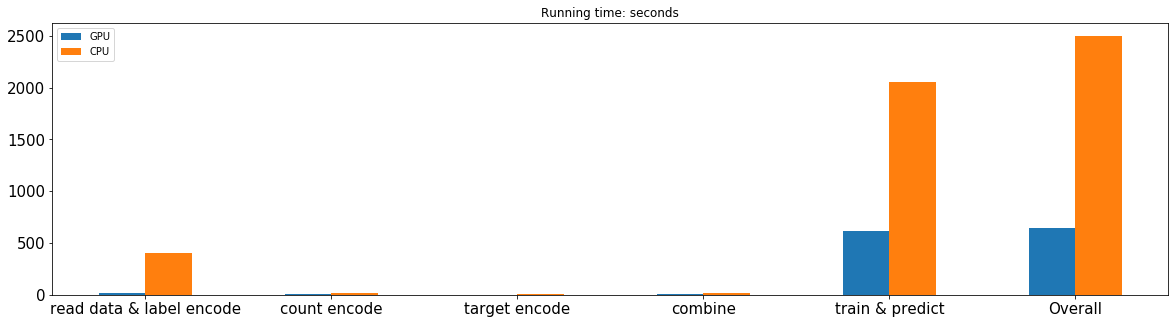

In [22]:
cpu_time = [timing_cpu[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time,'CPU': cpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')